In [2]:
import pandas as pd
import numpy as np

In [5]:
df_content_art = pd.read_pickle("df_content_art.pkl")

In [216]:
political_articles = np.load('political_articles.npy')

In [217]:
df_content_art = df_content_art.loc[df_content_art.ID_GodotObject.isin(political_articles),]
df_content_art.shape

(4260, 3)

In [218]:
import xml.etree.ElementTree as ET
import re

In [219]:
special_chars = ['<p>', '</p>', '<b>', '</b>', '</strong>', '<h3>', '</h3>']
def extract_features(data_list):
    features_list = []
    for xml_string in data_list:
        root = ET.fromstring(xml_string)
        # Find text and combine if multiple
        art_text = ''
        for text_i in root.iter('text'):
            if text_i.text is not None:
                art_text = art_text + '' + text_i.text
        # Clean text string        
        art_text = art_text.replace('\n', ' ')
        for char in special_chars:
            art_text = art_text.replace(char, '')
        art_text = re.sub("^\w+\s([-'])\s", "", art_text)  
         
        document_id = root.attrib['id']
        publishing_date = root.attrib['publishingDate']
        title_find = root.find('./title')
        if title_find is not None:
            title = title_find.text
        else:
            title = ""   
        lead_title_find = root.find('./leadTitle')
        if lead_title_find is not None:
            lead_title = lead_title_find.text
        else:
            lead_title = ""
        url = root.attrib['url']
        features = {'document_id': document_id, 'publishing_date': publishing_date, 'title': title, 'lead_title': lead_title, 'text': art_text, 'url': url}
        features_list.append(features)
  
    return features_list

In [88]:
from deep_translator import GoogleTranslator

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("valurank/distilroberta-mbfc-bias")

model = AutoModelForSequenceClassification.from_pretrained("valurank/distilroberta-mbfc-bias")

In [2]:
import pickle
from IPython.display import clear_output

In [220]:
starting_article = 0
#ending_article = 2000

#article_text = extract_features(df_content_art['documentXML'][starting_article:ending_article+1])
article_text = extract_features(df_content_art['documentXML'][starting_article:])

In [221]:

political_lean = []
article_count = starting_article
skipped_articles = []
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
for dict in article_text:
    print(article_count)
    text = dict['text'][:1850]
    if len(re.findall('http://', text)) > 3:
        skipped_articles.append(article_count)
        print(skipped_articles)
        continue
    text = text.rsplit(' ', 1)[0] 
    translated = GoogleTranslator(source='de', target='en').translate(text)
    try:
        pred_class = classifier(translated)
        pol_label = pred_class[0]['label']
        pol_score = pred_class[0]['score']
        class_dict = {'document_id' : dict['document_id'], 'pol_label' : pol_label, 'pol_score' : pol_score}
        political_lean.append(class_dict)
    except:
        continue    
    clear_output(wait=True) 
    article_count += 1
    if article_count % 100 == 0:
        with open("political_lean.bin", "wb") as output:
            pickle.dump(political_lean, output)


4001


In [222]:
len(political_lean)


4002

In [223]:
political_lean_df = pd.DataFrame(political_lean)
#political_lean_df.pol_label.value_counts()
political_lean_df
political_lean_df.to_pickle('political_lean_df_large.pkl')

In [3]:
# Import dfs with pol_label
political_lean_df_0_81 = pd.read_pickle('political_lean_df_0_81.pkl') 
political_lean_df_81_219 = pd.read_pickle('political_lean_df_81_219.pkl')
political_lean_df_225_235 = pd.read_pickle('political_lean_df_225_235.pkl')
political_lean_df_235_245 = pd.read_pickle('political_lean_df_235_245.pkl')
political_lean_df_245_1000 = pd.read_pickle('political_lean_df_245_1000.pkl')
political_lean_df_1000_2000 = pd.read_pickle('political_lean_df_1000_2000.pkl')
political_lean_df_2000_3120 = pd.read_pickle('political_lean_df_2000_3120.pkl')
political_lean_df_large = pd.read_pickle('political_lean_df_large.pkl')

political_lean = pd.concat([political_lean_df_0_81, political_lean_df_81_219, political_lean_df_225_235, 
                            political_lean_df_235_245, political_lean_df_245_1000, political_lean_df_1000_2000, 
                            political_lean_df_2000_3120, political_lean_df_large])


In [5]:
political_lean.to_pickle('political_lean_final.pkl')

In [4]:
df_dimcontent = pd.read_pickle("df_dimcontent.pkl")
df_dimcontent = df_dimcontent.loc[:,['SID_Content','ID_GodotObject', 'ChannelTopRessort', 'ObjectType']]

In [5]:
df_dimcontent.ID_GodotObject = df_dimcontent.ID_GodotObject.astype(str)
political_lean.document_id = political_lean.document_id.astype(str)

In [9]:
print(df_dimcontent.shape, political_lean.shape)


(1558554, 4) (7111, 3)


In [6]:
df_full = pd.merge(political_lean, df_dimcontent, how = 'inner', left_on='document_id', right_on='ID_GodotObject')
df_full.shape

(7111, 7)

In [7]:
df_full_labeled = df_full
df_full_labeled.loc[df_full_labeled.pol_label == 'extremeright', 'pol_label'] = 'right'
categories = pd.DataFrame(pd.crosstab(df_full.ChannelTopRessort, df_full.pol_label, margins = True))
categories[['left', 'leftcenter', 'leastbiased', 'rightcenter', 'right', 'unknown', 'All']] 


pol_label,left,leftcenter,leastbiased,rightcenter,right,unknown,All
ChannelTopRessort,,,,,,,
(Diverses),0,29,116,14,124,161,444
(Inland),0,139,26,0,171,1789,2125
(International),1,28,3,0,25,158,215
(Panorama),1,45,19,0,62,713,840
Europa,1,87,24,1,25,631,769
Kolumnen,0,26,0,0,26,295,347
Kommentare,3,69,8,2,18,481,581
Welt-Chronik,0,28,28,1,12,226,295
Wirtschaftspolitik,1,96,39,2,55,571,764


In [8]:
df_full_labeled = df_full.loc[df_full.pol_label != 'unknown',]
df_full_labeled.loc[df_full_labeled.pol_label == 'extremeright', 'pol_label'] = 'right'
cross_df = pd.DataFrame(pd.crosstab(df_full_labeled.ChannelTopRessort, df_full_labeled.pol_label))
cross_df = cross_df[['left', 'leftcenter', 'leastbiased', 'rightcenter', 'right']]
cross_df
#cross_df_values = cross_df.values.tolist()
#cross_df.index
#cross_df.columns
#cross_df[['left', 'leftcenter', 'leastbiased', 'rightcenter', 'right', 'extremeright', 'unknown']]

pol_label,left,leftcenter,leastbiased,rightcenter,right
ChannelTopRessort,,,,,
(Diverses),0,29,116,14,124
(Inland),0,139,26,0,171
(International),1,28,3,0,25
(Panorama),1,45,19,0,62
Europa,1,87,24,1,25
Kolumnen,0,26,0,0,26
Kommentare,3,69,8,2,18
Welt-Chronik,0,28,28,1,12
Wirtschaftspolitik,1,96,39,2,55


In [9]:
pd.crosstab(df_full.ChannelTopRessort, df_full.pol_label, normalize='index', margins=True)

pol_label,leastbiased,left,leftcenter,right,rightcenter,unknown
ChannelTopRessort,,,,,,
(Diverses),0.261261,0.000000,0.065315,0.279279,0.031532,0.362613
(Inland),0.012235,0.000000,0.065412,0.080471,0.000000,0.841882
(International),0.013953,0.004651,0.130233,0.116279,0.000000,0.734884
(Panorama),0.022619,0.001190,0.053571,0.073810,0.000000,0.848810
Europa,0.031209,0.001300,0.113134,0.032510,0.001300,0.820546
Kolumnen,0.000000,0.000000,0.074928,0.074928,0.000000,0.850144
Kommentare,0.013769,0.005164,0.118761,0.030981,0.003442,0.827883
Welt-Chronik,0.094915,0.000000,0.094915,0.040678,0.003390,0.766102
Wirtschaftspolitik,0.051047,0.001309,0.125654,0.071990,0.002618,0.747382


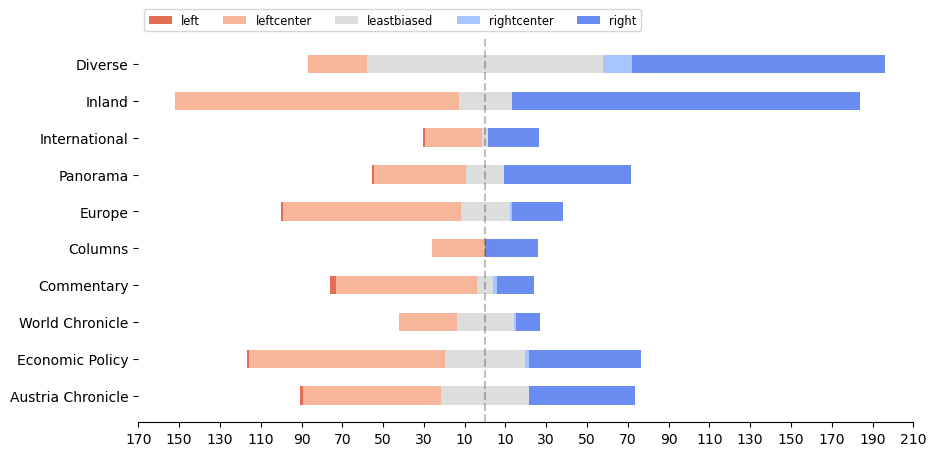

In [10]:
import numpy as np
import matplotlib.pyplot as plt


categories = ['Diverse',
'Inland',
'International',
'Panorama',
'Europe',
'Columns',
'Commentary',
'World Chronicle',
'Economic Policy',
'Austria Chronicle']


def survey(results, category_names, row_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = row_names
    data = np.array(results.values.tolist())
    #print(data)
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-170, 210)
    ax.set_xticks(np.arange(-170, 211, 20))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')

    return fig, ax


fig, ax = survey(cross_df, cross_df.columns, categories)

plt.show()

In [206]:
political_lean_df.loc[political_lean_df.pol_label == 'extremeright']


,document_id,pol_label,pol_score
513,2000123568600,extremeright,0.432725


In [207]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(df_content_art.loc[df_content_art.ID_GodotObject == 2000123568600,].url)

1751687    /2000123568600/Suedtirol-stellt-sich-die-Coron...
Name: url, dtype: object


In [176]:
pred_class = classifier(translated)

In [106]:
with open("output.bin", "rb") as data:
    political_articles = pickle.load(data)

'Der erste große Kollektivvertrag im Sozialbereich wurde am Dienstag von Caritas und Gewerkschaft unterzeichnet. Für Caritas-Präsident Franz Küberl handelt es sich bei diesem Vertrag um einen "Meilenstein" mit Signalwirkung für alle sozialen Organisationen und Einrichtungen. Die wesentlichen Errungenschaften für die 6.500 Mitarbeiter der Caritas-Organisationen sind flachere Gehaltskurven mit höheren Einstiegsgehältern, die 37,5-Stunden Woche und flexiblere Arbeitszeiten.  In über 70 Verhandlungsrunden wurde ein Kollektivvertrag ausgehandelt, der sowohl die Bedürfnisse der betreuten Menschen als auch familienfreundliche Lösungen für die MitarbeiterInnen im Auge habe, erklärte Raimund Badelt, Generalsekretär der Caritas Wien und Chefverhandler der Caritas, anlässlich der feierlichen Vertragsunterzeichnung. Aber auch die Gewerkschaft ist über den neuen Kollektivvertrag erfreut. "Der vorliegende Vertrag ist ein hervorragendes Beispiel für eine aktiv gelebte Sozialpartnerschaft. Das ist in 